In [1]:
from google.colab import drive 
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Automated Essay Scoring/Topic Classification

/content/drive/MyDrive/Automated Essay Scoring/Topic Classification


In [ ]:
!pip install transformers

#1. Prepare Dataset

##1.1 Read raw data and create labels

In [3]:
import pandas as pd
import numpy as np

import tensorflow as tf
import transformers #huggingface transformers library

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.metrics import confusion_matrix
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_json('/content/drive/MyDrive/Automated Essay Scoring/Topic Classification/News_Category_Dataset_v2.json', lines = True)

In [5]:
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [6]:
print(f"The dataset contains { df.category.nunique() } unique categories")

The dataset contains 41 unique categories


In [7]:
df.category = df.category.replace(['WELLNESS', 'HEALTHY LIVING'], 'HEALTH')
df.category = df.category.replace(['COMEDY'], 'ENTERTAINMENT')
df.category = df.category.replace(['TASTE'], 'FOOD & DRINK')
df.category = df.category.replace(['STYLE'], 'STYLE & BEAUTY')
df.category = df.category.replace(['CULTURE & ARTS', 'ARTS'], 'ARTS & CULTURE')
df.category = df.category.replace(['IMPACT', 'CRIME'], 'SOCIETY & CRIME')
df.category = df.category.replace(['PARENTING', 'PARENTS', 'WEDDINGS', 'DIVORCE'], 'FAMILY')
df.category = df.category.replace(['SCIENCE', 'TECH'], 'SCIENCE & TECH')
df.category = df.category.replace(['COLLEGE'], 'EDUCATION')
df.category = df.category.replace(['MONEY', 'HOME & LIVING', 'BUSINESS'], 'BUSINESS & FINANCE')
df.category = df.category.replace(['QUEER VOICES', 'BLACK VOICES', 'WOMEN'], 'GENDER & RACE')
df.category = df.category.replace(['GREEN'], 'ENVIRONMENT')
df.category = df.category.replace(['TRAVEL'], 'TRAVEL & TOURISM')
df.category = df.category.replace(['LATINO VOICES', 'WORLDPOST', 'THE WORLDPOST', 'POLITICS', 'WORLD NEWS', 'WEIRD NEWS', "FIFTY", "GOOD NEWS", 'MEDIA'], 'UNIDENTIFIED')
df.short_description = df.headline + df.short_description 
df = df.drop(columns=['headline', 'authors', 'link', 'date'])

In [8]:
print(f"The dataset contains { df.category.nunique() } unique categories")

The dataset contains 16 unique categories


In [9]:
df.head()

,category,short_description
0,SOCIETY & CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


In [10]:
#Show unique classes
categories = df.category.unique()
categories

array(['SOCIETY & CRIME', 'ENTERTAINMENT', 'UNIDENTIFIED',
       'GENDER & RACE', 'SPORTS', 'BUSINESS & FINANCE',
       'TRAVEL & TOURISM', 'SCIENCE & TECH', 'RELIGION', 'EDUCATION',
       'FAMILY', 'ARTS & CULTURE', 'STYLE & BEAUTY', 'ENVIRONMENT',
       'FOOD & DRINK', 'HEALTH'], dtype=object)

In [11]:
#label encoding the categories. After this each category would be mapped to an integer.
encoder = LabelEncoder()
df['categoryEncoded'] = encoder.fit_transform(df['category'])

In [12]:
df.head()

,category,short_description,categoryEncoded
0,SOCIETY & CRIME,There Were 2 Mass Shootings In Texas Last Week...,11
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,3
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...,3
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,3
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,3


In [13]:
#Convert description to lower case
df['short_description'] = df['short_description'].apply(lambda descr: str(descr).lower())
df.head()

,category,short_description,categoryEncoded
0,SOCIETY & CRIME,there were 2 mass shootings in texas last week...,11
1,ENTERTAINMENT,will smith joins diplo and nicky jam for the 2...,3
2,ENTERTAINMENT,hugh grant marries for the first time at age 5...,3
3,ENTERTAINMENT,jim carrey blasts 'castrato' adam schiff and d...,3
4,ENTERTAINMENT,julianna margulies uses donald trump poop bags...,3


In [14]:
#Calculate the length of description
df['descr_len'] = df['short_description'].apply(lambda x: len(str(x).split()))
df.head()

,category,short_description,categoryEncoded,descr_len
0,SOCIETY & CRIME,there were 2 mass shootings in texas last week...,11,26
1,ENTERTAINMENT,will smith joins diplo and nicky jam for the 2...,3,19
2,ENTERTAINMENT,hugh grant marries for the first time at age 5...,3,24
3,ENTERTAINMENT,jim carrey blasts 'castrato' adam schiff and d...,3,24
4,ENTERTAINMENT,julianna margulies uses donald trump poop bags...,3,25


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


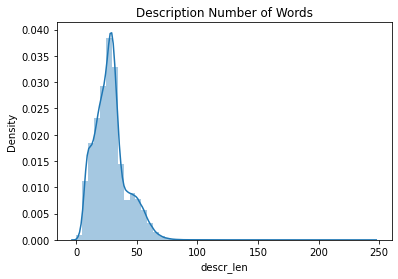

In [15]:
#Visualize the dataset
sns.distplot(df['descr_len'])
plt.title('Description Number of Words')
plt.show()

In [16]:
#Show number of classes
print(f"The dataset contains { df.category.nunique() } unique categories")

The dataset contains 16 unique categories


In [17]:
#Show dataset size
df.shape[0]

200853

In [18]:
"""to_remove = np.random.choice(df[df['category']=='UNIDENTIFIED'].index,size=45000,replace=False)
df = df.drop(to_remove)"""
to_remove = np.random.choice(df[df['category']=='ENTERTAINMENT'].index,size=15000,replace=False)
df = df.drop(to_remove)
to_remove = np.random.choice(df[df['category']=='STYLE & BEAUTY'].index,size=5000,replace=False)
df = df.drop(to_remove)
to_remove = np.random.choice(df[df['category']=='BUSINESS & FINANCE'].index,size=5000,replace=False)
df = df.drop(to_remove)
to_remove = np.random.choice(df[df['category']=='HEALTH'].index,size=15000,replace=False)
df = df.drop(to_remove)
to_remove = np.random.choice(df[df['category']=='GENDER & RACE'].index,size=5000,replace=False)
df = df.drop(to_remove)
to_remove = np.random.choice(df[df['category']=='FAMILY'].index,size=10000,replace=False)
df = df.drop(to_remove)


In [19]:
df.shape[0]

145853

In [20]:
#Number of examples in each class 
df.groupby('category').count()

,short_description,categoryEncoded,descr_len
category,,,
ARTS & CULTURE,3878,3878,3878
BUSINESS & FINANCE,6839,6839,6839
EDUCATION,2148,2148,2148
ENTERTAINMENT,6233,6233,6233
ENVIRONMENT,3945,3945,3945
FAMILY,9709,9709,9709
FOOD & DRINK,8322,8322,8322
GENDER & RACE,9332,9332,9332
HEALTH,9521,9521,9521


##1.2 Tokenizing Data

In [21]:
#Convert texts to ids 
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_mask =False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [22]:
import pickle

def _save_pickle(path, obj):
  with open(path, 'wb') as f:
    pickle.dump(obj, f)

def _load_pickle(path):
  with open(path, 'rb') as f:
    obj = pickle.load(f)
  return obj
  


Download tokenizer from huggingface

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

Save or load tokenizer

In [ ]:
_save_pickle("encoder.pkl", encoder)

In [ ]:
_save_pickle("tokenizer.pkl", tokenizer)

In [23]:
tokenizer = _load_pickle("tokenizer.pkl")

Split the dataset to train and test set (for validation)

In [24]:
X_train,X_test ,y_train,y_test = train_test_split(df['short_description'], df['categoryEncoded'], random_state = 2020, test_size = 0.1)

In [25]:
X_train.shape[0]

131267

In [26]:
Xtrain_encoded = regular_encode(X_train.astype('str'), tokenizer, maxlen=80)
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes=16,dtype = 'int32')
Xtest_encoded = regular_encode(X_test.astype('str'), tokenizer, maxlen=80)
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes=16,dtype = 'int32')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


#2. Define Model

In [28]:
def build_model(transformer, loss='categorical_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    #adding dropout layer
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    #using a dense layer of 16 neurons as the number of unique categories is 16. 
    out = tf.keras.layers.Dense(16, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    #using categorical crossentropy as the loss as it is a multi-class classification problem
    model.compile(tf.keras.optimizers.Adam(lr=3e-5), loss=loss, metrics=['accuracy'])
    return model



Configure TPU for training

In [30]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.79.64.210:8470


INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.79.64.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.64.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [31]:
with strategy.scope():
  transformer_layer = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
  model = build_model(transformer_layer, max_len=80)
model.summary()

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 80)]              0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 335141888 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 1024)              0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                16400     
Total params: 335,158,288
Trainable params: 335,158,288
Non-trainable params: 0
_________________________________________________________________


Save the bert model for next time

In [32]:
transformer_layer.save_pretrained("saved_model")

Load saved bert model

In [ ]:
tf = transformers.TFAutoModel.from_pretrained('saved_model')

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at saved_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


#3. Train model

In [33]:
BATCH_SIZE = 32*strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE 
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xtrain_encoded, ytrain_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xtest_encoded,ytest_encoded))
    .batch(BATCH_SIZE)
)

In [34]:
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    epochs=10,
    validation_data=test_dataset
)


Epoch 1/10


512/512 [==============================] - ETA: 0s - loss: 1.1719 - accuracy: 0.6478WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


512/512 [==============================] - 423s 519ms/step - loss: 1.1714 - accuracy: 0.6480 - val_loss: 0.6964 - val_accuracy: 0.7771
Epoch 2/10
512/512 [==============================] - 248s 484ms/step - loss: 0.6820 - accuracy: 0.7817 - val_loss: 0.6780 - val_accuracy: 0.7820
Epoch 3/10
512/512 [==============================] - 247s 483ms/step - loss: 0.5972 - accuracy: 0.8094 - val_loss: 0.6947 - val_accuracy: 0.7847
Epoch 4/10
512/512 [==============================] - 247s 483ms/step - loss: 0.4296 - accuracy: 0.8608 - val_loss: 0.7667 - val_accuracy: 0.7823
Epoch 5/10
512/512 [==============================] - 247s 483ms/step - loss: 0.3057 - accuracy: 0.9019 - val_loss: 0.8967 - val_accuracy: 0.7819
Epoch 6/10
512/512 [==============================] - 247s 483ms/step - loss: 0.2064 - accuracy: 0.9320 - val_loss: 1.0058 - val_accuracy: 0.7780
Epoch 7/10
512/512 [==============================] - 247s 483ms/step - loss: 0.1322 - accuracy: 0.9554 - val_loss: 1.0920 - val_accura

In [35]:
model.save_weights('model_weights.h5')

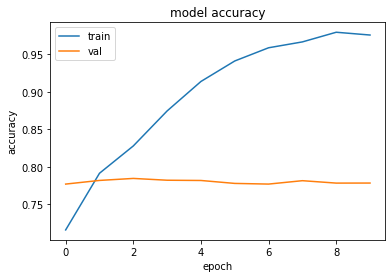

In [37]:
from matplotlib import pyplot as plt
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#4. Test

In [83]:
test = "Creative people  should always be given freedom to express their own ideas (in words, pictures, music or film) in whichever way they wish. There should be no government restrictions on what they do. To what extent do you agree or disagree on this IELTS topic?"

In [84]:
test_encoded = regular_encode([test], tokenizer, maxlen=80)
pred = model.predict([test_encoded],verbose = 1)
pred_classes = np.argmax(pred, axis = 1)
#extracting the classes from the label encoder
encoded_classes = encoder.classes_
#mapping the encoded output to actual categories
predicted_category = [encoded_classes[x] for x in pred_classes]
predicted_category

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


1/1 [==============================] - 1s 542ms/step


['ARTS & CULTURE']

#5. Evaluation

In [85]:
preds = model.predict(test_dataset,verbose = 1)

57/57 [==============================] - 27s 341ms/step


In [93]:
pred_classes = np.argmax(preds, axis = 1)

In [94]:
#extracting the classes from the label encoder
encoded_classes = encoder.classes_
#mapping the encoded output to actual categories
predicted_category = [encoded_classes[x] for x in pred_classes]
true_category = [encoded_classes[x] for x in y_test]

In [95]:
print(X_test.shape)
print(len(true_category))
print(len(predicted_category))


(14586,)
14586
14586


In [96]:
result_df = pd.DataFrame({'description':X_test,'true_category':true_category, 'predicted_category':predicted_category})
result_df.head()

,description,true_category,predicted_category
22113,opioid prescriptions are declining -- but not ...,HEALTH,UNIDENTIFIED
2839,adam rippon makes it official with his new fin...,GENDER & RACE,ENTERTAINMENT
98236,"catholic church: it's not me, it's youthere is...",RELIGION,RELIGION
117953,parents debate: should you send your kids to c...,FAMILY,FAMILY
182912,repurposing ideas: 5 uses for cards that don't...,BUSINESS & FINANCE,BUSINESS & FINANCE


In [97]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(result_df['true_category'], result_df['predicted_category'])}")

Accuracy is 0.7784862196626903


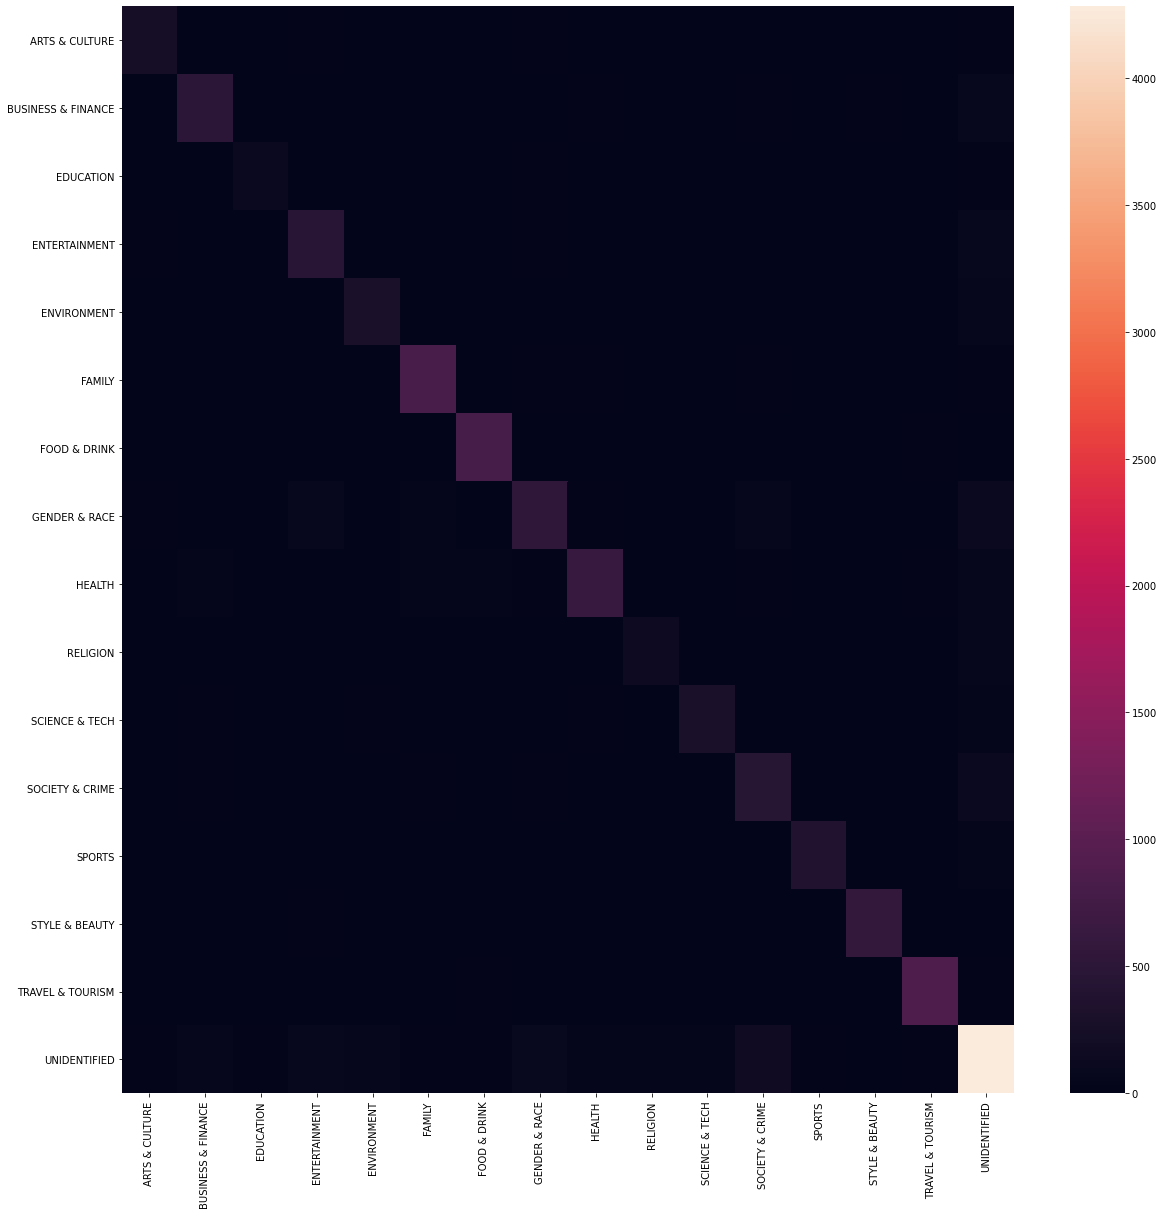

In [99]:
result_df[result_df['true_category']!=result_df['predicted_category']]
confusion_mat = confusion_matrix(y_true = true_category, y_pred = predicted_category, labels=list(encoded_classes))
df_cm = pd.DataFrame(confusion_mat, index = list(encoded_classes),columns = list(encoded_classes))
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(df_cm)

